<a href="https://colab.research.google.com/github/SenanS/Machine-Vision-Lane-Detection/blob/main/MVGCV_Lane_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lane Detection and Recognition

Lane detection, recognition and segmentation are pivotal problems in the automotive industry as mainstream autonomous vehicles (AV) teeter on the precipice of market penetration. This code introduces a lane detection method based on classical computer vision techniques which performs robustly on a variety of lane-hand drive Irish roads. Data is extracted from a video stream frame-by-frame, filtered and processed to find likely lane markings and graphically represents these markings on the original frames.

In [1]:
from google.colab import drive
colab_path = '/content/drive/'
video_path = colab_path + 'MyDrive/MVGCV/'
drive.mount(colab_path)

Mounted at /content/drive/


In [2]:
import matplotlib.pylab as plt
import cv2
import math
import numpy as np

In [3]:
video = cv2.VideoCapture(video_path + 'DualcarriagewayAndTown.mp4')

# Check if video opened successfully
if (video.isOpened()== False):
    print("Error opening Video")

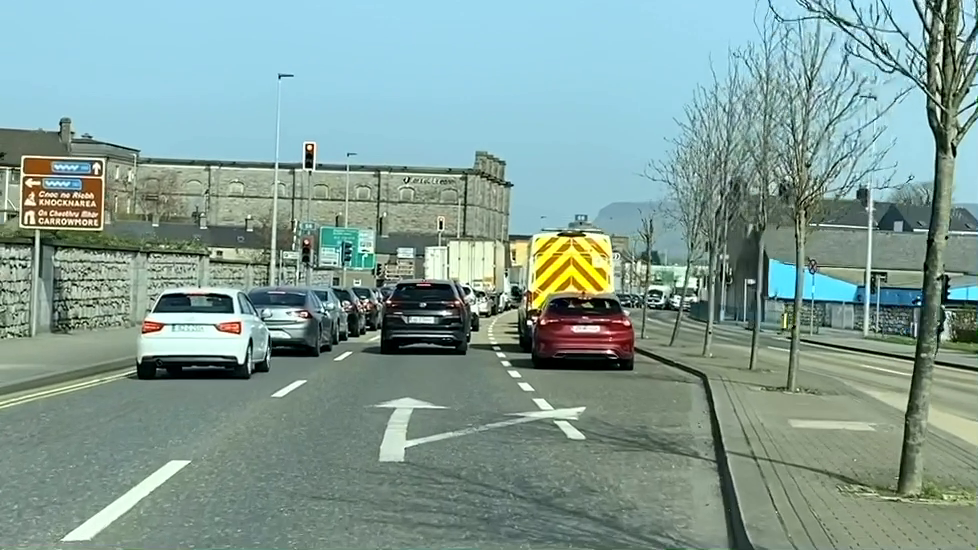

In [41]:
from google.colab.patches import cv2_imshow
# ret, frame = video.read()
ret = video.set( 1, 5000)
ret, frame = video.read()

if ret == True:
    cv2_imshow(frame)


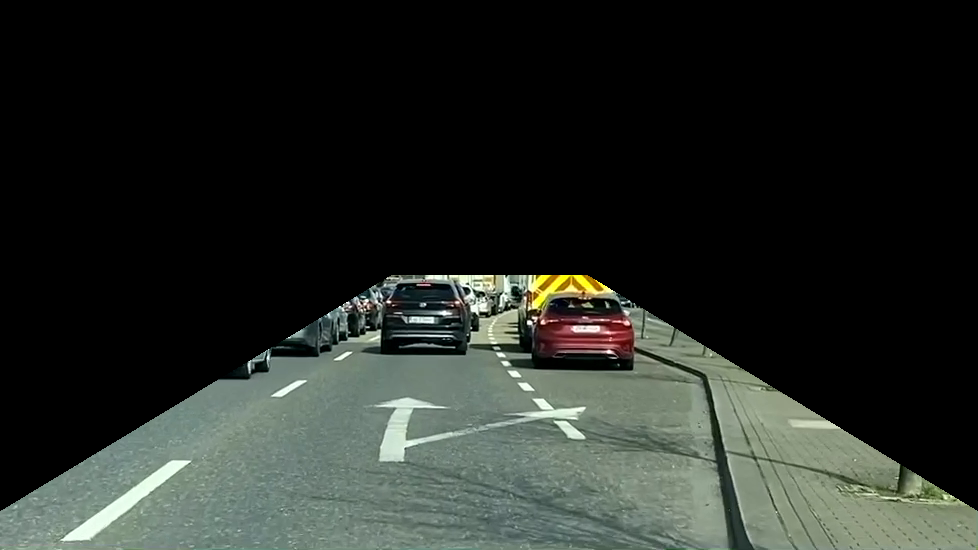

In [42]:
ysize,xsize = frame.shape[0:2]

# Create a trapezoidal area of interest
og_dx1 = int(0.0 * xsize)
og_dx2 = int(0.4 * xsize)

og_dy1  = int(0.5 * ysize)
og_dy2  = int(0.93 * ysize)
# calculate vertices for polygon of interest
vertices = np.array([[(og_dx1, ysize),
                      (og_dx1, og_dy2),
                      (og_dx2, og_dy1),
                      (xsize - og_dx2, og_dy1),
                      (xsize - og_dx1, og_dy2),
                      (xsize - og_dx1, ysize)
                      ]], dtype=np.int32)

# Define a blank mask
mask = np.zeros_like(frame)

# Fill in pixels inside the trapezoid
cv2.fillPoly(mask, vertices, color=(255,255,255))

# Mask the trapezoidal area
trapped_image = cv2.bitwise_and(frame, mask)
cv2_imshow(trapped_image)

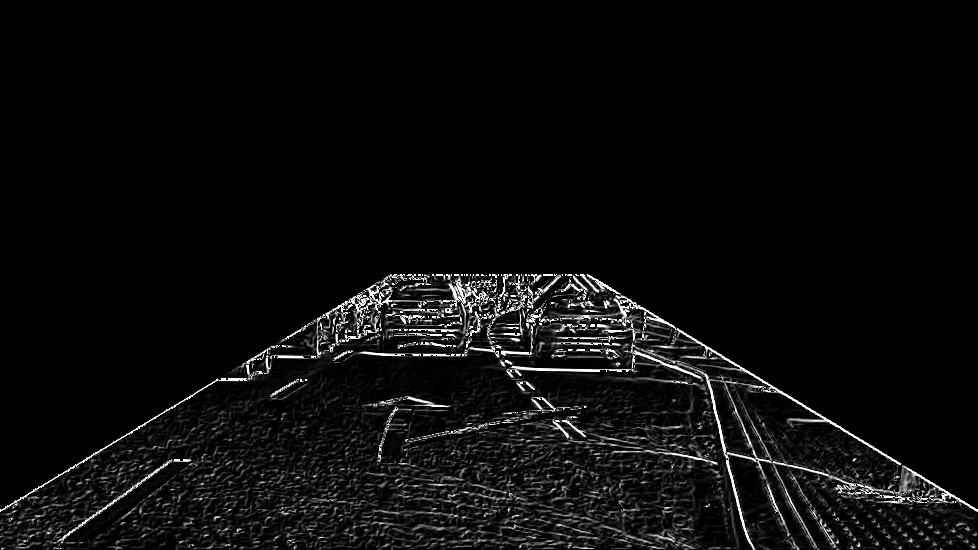

In [43]:
grey = cv2.cvtColor(trapped_image,cv2.COLOR_BGR2GRAY)
# blur = cv2.GaussianBlur(gray,(1,1),1000)

sobel_x_filter = cv2.Sobel(grey, ddepth=-1, dx=1, dy=0, scale=1, borderType=cv2.BORDER_DEFAULT)
sobel_y_filter = cv2.Sobel(grey, ddepth=-1, dx=0, dy=1, scale=1, borderType=cv2.BORDER_DEFAULT)

# scharr_x_filter = cv2.Scharr(grey, ddepth=-1, dx=1, dy=0, scale=1, borderType=cv2.BORDER_DEFAULT)
# scharr_y_filter = cv2.Scharr(grey, ddepth=-1, dx=0, dy=1, scale=1, borderType=cv2.BORDER_DEFAULT)


sobel_filter = sobel_x_filter + sobel_y_filter
# scharr_filter = scharr_x_filter + scharr_y_filter
cv2_imshow(sobel_filter)
# cv2_imshow(scharr_filter)

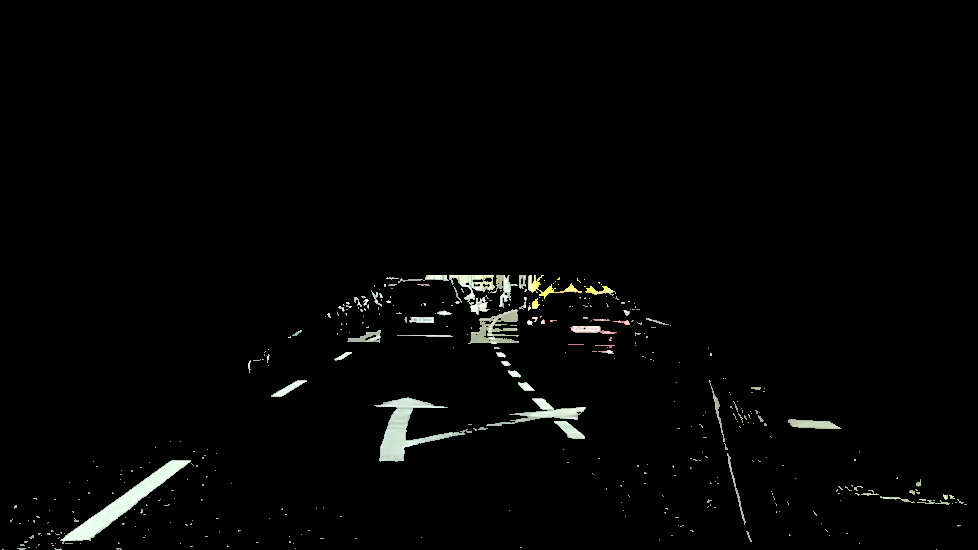

In [44]:
hls_frame = cv2.cvtColor(trapped_image,cv2.COLOR_BGR2HLS)

hls_mask = cv2.inRange(hls_frame, (0,160,0), (359,255,255))

hls_masked_image = cv2.bitwise_and(frame,frame, mask=hls_mask)
cv2_imshow(hls_masked_image)

In [45]:
hls_grey = cv2.cvtColor(hls_masked_image,cv2.COLOR_BGR2GRAY)
combined_image = cv2.bitwise_and(sobel_filter, hls_grey)
# cv2_imshow(combined_image)

In [46]:
# Prepocess
# gray = cv2.cvtColor(combined_image,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(combined_image,(1,1),1000)
flag, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY)

# Taking a matrix of size 2 as the kernel
kernel = np.ones((2,2), np.uint8)

# The first parameter is the original image,
# kernel is the matrix with which image is
# convolved and third parameter is the number
# of iterations, which will determine how much
# you want to erode/dilate a given image.
img_erosion = cv2.erode(thresh, kernel, iterations=1)
img_dilation = cv2.dilate(img_erosion, kernel, iterations=1)
img_erosion1 = cv2.erode(img_dilation, kernel, iterations=1)
img_dilation2 = cv2.dilate(img_erosion1, kernel, iterations=1)
# img_erosion2 = cv2.erode(img_dilation2, kernel, iterations=1)
# img_dilation3 = cv2.dilate(img_erosion2, kernel, iterations=1)
# img_erosion3 = cv2.erode(img_dilation3, kernel, iterations=1)


# cv2_imshow(combined_image)
# cv2_imshow(img_dilation2)

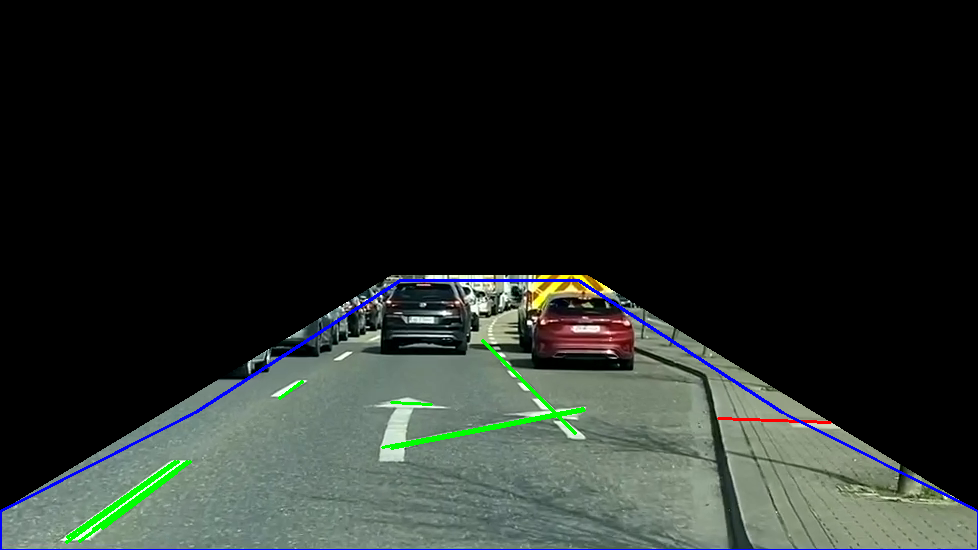

In [47]:
# Create a smaller trapezoidal area of interest
dx1 = int(0.00 * xsize)
dx2 = int(0.41 * xsize)
dy  = int(0.51 * ysize)

step_factor = 0.5
step_offset = ((og_dx2 - dx2)**2 + (og_dy1-dy)**2)**0.5

og_dy2  = int(0.93 * ysize)

# calculate vertices for augmented trapezoid
shrunk_vertices = np.array([[(dx1,                                        ysize),
                             (dx1,                                        og_dy2),
                             (og_dx2*step_factor,                         (ysize-og_dy1)/2+og_dy1),
                            #  (og_dx2*step_factor + step_offset,           (ysize-og_dy)/2+og_dy),
                             (dx2,                                        dy),
                             (xsize - dx2,                                dy),
                            #  (xsize - og_dx2*step_factor - step_offset,   (ysize-og_dy)/2+og_dy),
                             (xsize - og_dx2*step_factor,                 (ysize-og_dy1)/2+og_dy1),
                             (xsize - dx1,                                og_dy2),
                             (xsize - dx1,                                ysize)
                             ]], dtype=np.int32)


# Find Edges and Apply Hough Transform for lines
edges = cv2.Canny(img_dilation2,0,255,apertureSize = 3)
lines = cv2.HoughLinesP(edges,1,np.pi/180,50,minLineLength=20,maxLineGap=50)

img = trapped_image.copy()
final_lines = []

# Plot all lines in red
for line in lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

# Plot filtered lines in green
for line in lines:
    x1,y1,x2,y2 = line[0]
    if (0 <= cv2.pointPolygonTest(shrunk_vertices, (float(x1),float(y1)), True)) and (0 <= cv2.pointPolygonTest(shrunk_vertices, (float(x2),float(y2)), True)):
      cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
      final_lines.append(line)

# Plot Polyline filter in blue
cv2.polylines(img,shrunk_vertices,True,(255,0,0),2)

cv2_imshow(img)

296.98484809834997


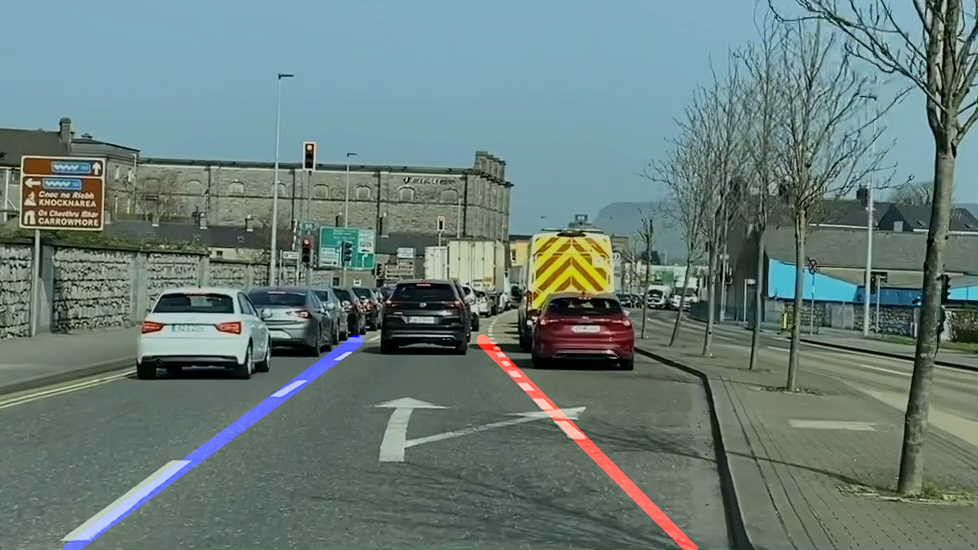

In [48]:
CACHE_LEFT_SLOPE = 0
CACHE_RIGHT_SLOPE = 0
CACHE_LEFT = [0, 0, 0]
CACHE_RIGHT = [0, 0, 0]

drawn_img = np.zeros_like(frame)

draw_lines(drawn_img, final_lines, (255,0,0), (0,0,255))

processed_img = cv2.addWeighted(frame, 0.8, drawn_img, 1, 0)

cv2_imshow(processed_img)

In [50]:
def draw_lines(img, lines,color_left,color_right,thickness=12):

    global CACHE_LEFT_SLOPE
    global CACHE_RIGHT_SLOPE
    global CACHE_LEFT
    global CACHE_RIGHT

    # DECLARE VARIABLES
    cache_weight = 0.9

    right_ys = []
    right_xs = []
    right_slopes = []

    left_ys = []
    left_xs = []
    left_slopes = []

    r_thresh = img.shape[1] *.4
    l_thresh = img.shape[1] *.6

    bottom_of_image = img.shape[0]

    for line in lines:
        for x1,y1,x2,y2 in line:
            slope, yint = np.polyfit((x1, x2), (y1, y2), 1)
            # Filter lines using slope and x position
            if .3 < np.absolute(slope) <= 3:
                if slope > 0 and x1 > r_thresh and x2 > r_thresh:
                    right_ys.append(y1)
                    right_ys.append(y2)
                    right_xs.append(x1)
                    right_xs.append(x2)
                    right_slopes.append(slope)
                elif slope < 0 and x1 < l_thresh and x2 < l_thresh:
                    left_ys.append(y1)
                    left_ys.append(y2)
                    left_xs.append(x1)
                    left_xs.append(x2)
                    left_slopes.append(slope)


    # DRAW RIGHT LANE LINE
    if right_ys:
        right_index = right_ys.index(min(right_ys))
        right_x1 = right_xs[right_index]
        right_y1 = right_ys[right_index]
        right_slope = np.median(right_slopes)
        if CACHE_RIGHT_SLOPE != 0:
            right_slope = right_slope + (CACHE_RIGHT_SLOPE - right_slope) * cache_weight

        right_x2 = int(right_x1 + (bottom_of_image - right_y1) / right_slope)

        if CACHE_RIGHT_SLOPE != 0:
            right_x1 = int(right_x1 + (CACHE_RIGHT[0] - right_x1) * cache_weight)
            right_y1 = int(right_y1 + (CACHE_RIGHT[1] - right_y1) * cache_weight)
            # right_x2 = int(right_x2 + (CACHE_RIGHT[2] - right_x2) * cache_weight)

        length = ((right_x1-right_x2)**2+(bottom_of_image-right_y1)**2)**0.5
        # print(length)
        if (250 > length):
          phi = math.atan(right_slope)
          right_y1 = int(bottom_of_image - 250*math.sin(phi))
          right_x1 = int(right_x2 - 250*math.cos(phi))

        CACHE_RIGHT_SLOPE = right_slope
        CACHE_RIGHT = [right_x1, right_y1, right_x2]



    # DRAW LEFT LANE LINE
    if left_ys:
        left_index = left_ys.index(min(left_ys))
        left_x1 = left_xs[left_index]
        left_y1 = left_ys[left_index]
        left_slope = np.median(left_slopes)
        if CACHE_LEFT_SLOPE != 0:
            left_slope = left_slope + (CACHE_LEFT_SLOPE - left_slope) * cache_weight

        left_x2 = int(left_x1 + (bottom_of_image - left_y1) / left_slope)

        if CACHE_LEFT_SLOPE != 0:
            left_x1 = int(left_x1 + (CACHE_LEFT[0] - left_x1) * cache_weight)
            left_y1 = int(left_y1 + (CACHE_LEFT[1] - left_y1) * cache_weight)
            left_x2 = int(left_x2 + (CACHE_LEFT[2] - left_x2) * cache_weight)

        CACHE_LEFT_SLOPE = left_slope
        CACHE_LEFT = [left_x1, left_y1, left_x2]

    # Interception code
    if left_ys and right_ys:
        x_intersect = (left_slope*left_x2 - right_slope*right_x2)/(left_slope - right_slope)
        y_intersect = left_slope*(x_intersect - left_x2) + bottom_of_image

        left_int_length = ((left_x2-x_intersect)**2+(bottom_of_image-y_intersect)**2)**0.5
        right_int_length = ((right_x2-x_intersect)**2+(bottom_of_image-y_intersect)**2)**0.5

        left_length = ((left_x1-left_x2)**2+(bottom_of_image-left_x1)**2)**0.5
        right_length = ((right_x1-right_x2)**2+(bottom_of_image-right_y1)**2)**0.5

        if (left_int_length >= left_length):
          phi = math.atan(left_slope)
          left_y1 = int(bottom_of_image + left_int_length*0.8*math.sin(phi))
          left_x1 = int(left_x2 + left_int_length*0.8*math.cos(phi))

        print(right_length)
        if (right_int_length <= right_length):
          phi = math.atan(right_slope)
          right_y1 = int(bottom_of_image - right_int_length*0.8*math.sin(phi))
          right_x1 = int(right_x2 - right_int_length*0.8*math.cos(phi))

    if left_ys:
      cv2.line(img, (left_x1, left_y1), (left_x2, bottom_of_image), color_left, thickness)
    if right_ys:
      cv2.line(img, (right_x1, right_y1), (right_x2, bottom_of_image), color_right, thickness)

In [ ]:
video.release()
# Closes all the frames
cv2.destroyAllWindows()

In [51]:
ysize,xsize = frame.shape[0:2]

# Create a trapezoidal area of interest
dx1 = int(0.0 * xsize)
dx2 = int(0.4 * xsize)
dy = int(0.4 * ysize)
# calculate vertices for trapezoid
vertices = np.array([[(dx1, ysize), (dx2, dy), (xsize - dx2, dy), (xsize - dx1, ysize)]], dtype=np.int32)

# Converting image to grayscale
grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Applying a gaussian blur mask on the gray image
blur = cv2.GaussianBlur(grey, (5, 5), 0)

# detecting edges in the image
edges = cv2.Canny(blur, 25, 100)

# Defining the region  of interest
mask = np.zeros_like(edges)
cv2.fillPoly(mask, vertices, 255)
masked = cv2.bitwise_and(edges, mask)

mask = np.zeros_like(frame).astype(np.uint8)
cv2.fillPoly(mask, [vertices], (255,255,255))
img_r_2= cv2.bitwise_and(mask,frame)

new_img=cv2.bitwise_and(img_r_2,img_r_2,mask=masked)
new_img=cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)

# Performing Hough transform to detect lanes
lines = cv2.HoughLinesP(new_img, 1, np.pi/180, 40, np.array([]), minLineLength=200, maxLineGap=50)
hough_image = np.zeros((*new_img.shape, 3), dtype=np.uint8)

# for line in lines:
#     x1,y1,x2,y2 = line[0]
#     cv2.line(img_r_2,(x1,y1),(x2,y2),(0,255,0),2)
# cv2_imshow(masked)


In [52]:
# Source points for homography.
bird_eye_coords_= np.float32([[410,335], [535, 334], [780, 479], [150, 496]])
# bird_eye_coords_=np.float32([[422,321],[540,330],[790,485],[80,500]])
# Destination points for homography
world_coords_ = np.float32([[50, 0], [250, 0], [250, 500], [0, 500]])

h_, mask = cv2.findHomography( bird_eye_coords_,world_coords_,cv2.RANSAC,5.0)

warped = cv2.warpPerspective(masked,h_,(300,600),flags=cv2.INTER_LINEAR)

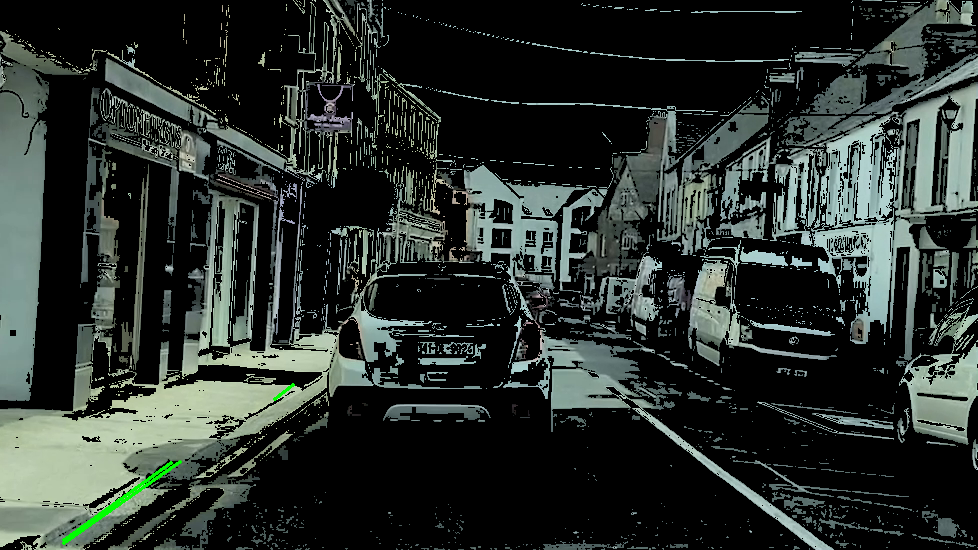

In [53]:
# gray = cv2.cvtColor(img_erosion3,cv2.COLOR_BGR2GRAY)
# blur = cv2.GaussianBlur(gray,(1,1),1000)
# flag, thresh = cv2.threshold(blur, 80, 255, cv2.THRESH_BINARY)
edges = cv2.Canny(img_dilation2,0,255,apertureSize = 7)
lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength=10,maxLineGap=15)
imgHoughed = target.copy()
for line in lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(imgHoughed,(x1,y1),(x2,y2),(0,255,0),2)
cv2_imshow(imgHoughed)

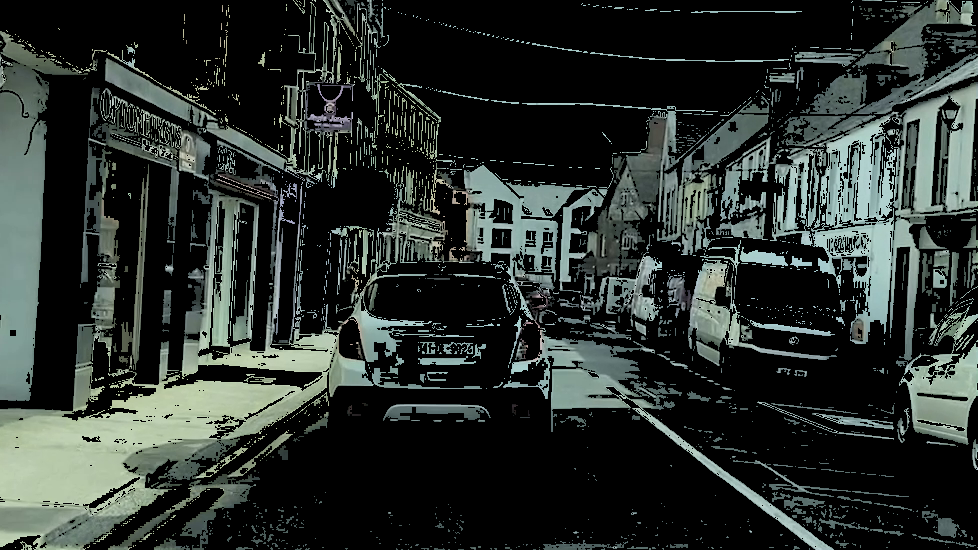

In [18]:
hsv_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)

# Mask the grey of the tarmac
hsv_frame = cv2.GaussianBlur(hsv_frame,(1,1),1000)
mask = cv2.inRange(hsv_frame, (0,10,30), (179,50,210))

target = cv2.bitwise_and(frame,frame, mask=mask)
cv2_imshow(target)

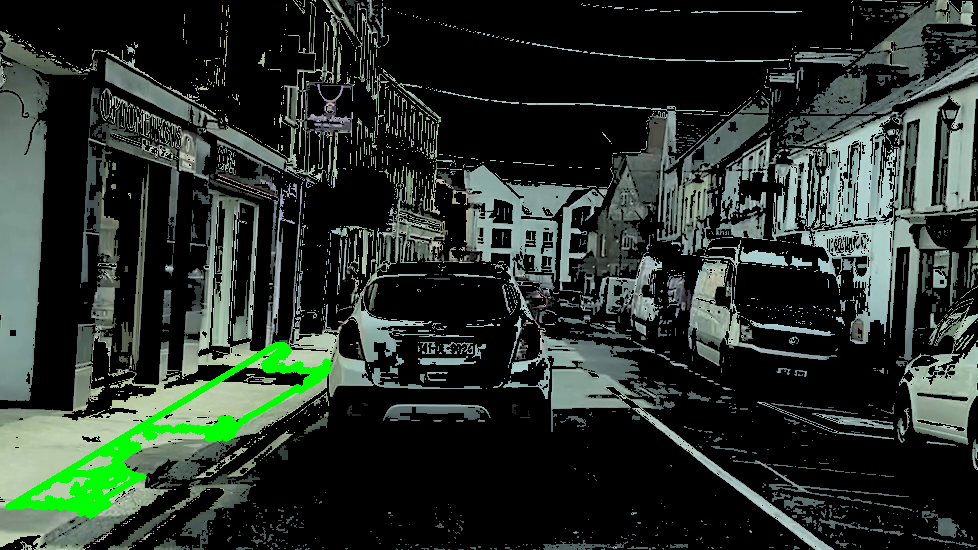

In [19]:
# Prepocess
# gray = cv2.cvtColor(target,cv2.COLOR_BGR2GRAY)
# blur = cv2.GaussianBlur(gray,(1,1),1000)
# flag, thresh = cv2.threshold(blur, 80, 255, cv2.THRESH_BINARY)
# Find contours
contours, hierarchy = cv2.findContours(combined_image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea,reverse=True)
# Select long perimeters only
perimeters = [cv2.arcLength(contours[i],True) for i in range(len(contours))]
listindex=[i for i in range(15) if perimeters[i]>perimeters[0]/2]
numcards=len(listindex)
# Show image
imgcont = target.copy()
[cv2.drawContours(imgcont, [contours[i]], 0, (0,255,0), 5) for i in listindex]
cv2_imshow(imgcont)

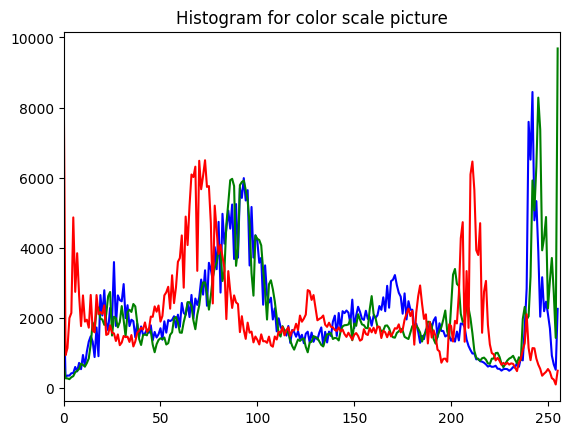

In [20]:

height, width, depth = frame.shape

color = ('b','g','r')
for channel,col in enumerate(color):
    histr = cv2.calcHist([frame],[channel],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.title('Histogram for color scale picture')
plt.show()


In [21]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)

## Inspirations and sources
* https://github.com/bharadwaj-chukkala/Road-Lanes-detection-and-Turn-Prediction-using-Sliding-Window-Algorithm/blob/master/Lane_Detection.py
* https://github.com/silenc3502/PyOCVLaneDetect/blob/master/P1.ipynb
* https://github.com/silenc3502/PyAdvancedLane/blob/master/doit.ipynb
* https://www.sciencedirect.com/science/article/pii/S2214785320373302?casa_token=9_yFfncWoRIAAAAA:LoAM-vsl4Sb2JOpQ2cYtQyZY7sadoVVX5wIujeV3-rHMFDT6AljVKooSvG-BQZH_51Ro2LwJng#f0040
* https://medium.com/@ldesegur/a-lane-detection-approach-for-self-driving-vehicles-c5ae1679f7ee
* https://opencv.org/evaluating-opencvs-new-ransacs/
